## Lung Cancer detection from CT scan images usig InceptionNet



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense,Conv2D,MaxPooling2D, AveragePooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.densenet import DenseNet169, DenseNet201

from keras.constraints import maxnorm

import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.preprocessing import image



In [ ]:
base_model = InceptionV3(input_shape=(512,512,3), include_top=False, weights='imagenet')
base_model.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
fl_layer = Flatten()
fc_layer1 = Dense(64, activation='relu')
fc_layer2 = Dense(32, activation='relu')
fc_layer3 = Dense(16, activation='relu')
#fc_layer4 = Dense(8, activation='relu')

In [ ]:
top_layer = Dense(1, activation='sigmoid')

In [ ]:
model = Sequential([base_model, fl_layer, fc_layer1, fc_layer2, fc_layer3, top_layer])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
#os.getcwd()
os.chdir('/content/drive/My Drive')
os.getcwd()

'/content/drive/My Drive'

In [ ]:
## data importing  scaling, creating additional images using shear, zoom, and flip

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, rotation_range=40, horizontal_flip=True
                                   #preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
                                   #height_shift_range=0.2,
                                   #width_shift_range=0.2
                             )

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
## Importing training data
train_set = train_datagen.flow_from_directory('Train/',target_size=(512, 512),class_mode='binary', batch_size=32)

Found 1623 images belonging to 2 classes.


In [ ]:
train_set.class_indices  # identify the classes 

{'Cancer': 0, 'Normal': 1}

In [ ]:
## Importng test data
test_set = test_datagen.flow_from_directory('Val/',target_size=(512, 512),class_mode='binary', batch_size=32)

Found 384 images belonging to 2 classes.


In [ ]:
metric = tf.keras.metrics.Recall(thresholds=0.4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metric)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 64)                25690176  
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 47,495,585
Trainable params: 25,692,801
No

In [ ]:
# Train the model
chkp_filepath = '/tmp/checkp'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=chkp_filepath,
    save_weights_only=True,
    monitor=metric,
    mode='max',
    save_best_only=True
)
r = model.fit(train_set,epochs=60,validation_data=test_set, callbacks=model_checkpoint_callback)

Epoch 1/60
51/51 [==============================] - 125s 2s/step - loss: 1.2876 - recall_1: 0.7441 - val_loss: 1.3949 - val_recall_1: 1.0000
Epoch 2/60
51/51 [==============================] - 128s 2s/step - loss: 0.8247 - recall_1: 0.8281 - val_loss: 0.9770 - val_recall_1: 1.0000
Epoch 3/60
51/51 [==============================] - 126s 2s/step - loss: 0.7209 - recall_1: 0.8272 - val_loss: 0.7857 - val_recall_1: 0.9920
Epoch 4/60
51/51 [==============================] - 126s 2s/step - loss: 0.6302 - recall_1: 0.8857 - val_loss: 0.5861 - val_recall_1: 0.9363
Epoch 5/60
51/51 [==============================] - 126s 2s/step - loss: 0.6066 - recall_1: 0.9056 - val_loss: 0.7077 - val_recall_1: 0.6215
Epoch 6/60
51/51 [==============================] - 126s 2s/step - loss: 0.6244 - recall_1: 0.8980 - val_loss: 0.6068 - val_recall_1: 0.9124
Epoch 7/60
51/51 [==============================] - 124s 2s/step - loss: 0.5813 - recall_1: 0.9112 - val_loss: 0.5555 - val_recall_1: 0.9801
Epoch 8/60
51

In [ ]:
model.load_weights(chkp_filepath)

NotFoundError: ignored

In [ ]:
import matplotlib.pyplot as plt

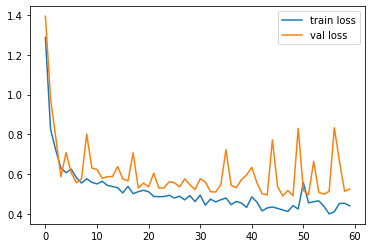

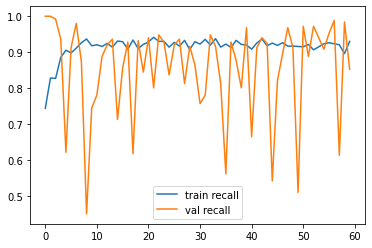

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['recall_1'], label='train recall')
plt.plot(r.history['val_recall_1'], label='val recall')
plt.legend()
plt.show()
plt.savefig('recall_acc')

In [ ]:
model.save('LungInceptionv3r.h5')

In [ ]:
## prediction of single new data

test_image= image.load_img('Test/Cancer/L-SC021-IMG-0001-00015.jpg',target_size=(512,512))


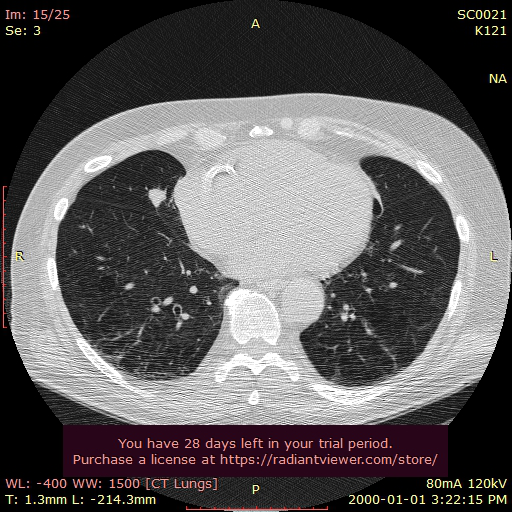

In [ ]:
test_image

In [ ]:
## Convert image to array
test_image = image.img_to_array(test_image)

In [ ]:
## For single prediction change the dimension . 

test_image=test_image.reshape(1,512,512,3)

In [ ]:
result = model.predict(test_image)

In [ ]:
result = np.around(result)

In [ ]:
if result == 0:
  prediction = 'Cancer'
else:
  prediction = 'Normal'

In [ ]:
prediction

'Normal'